# Geron Book - Ch 4: Training Models

## Chapter Overview

Look at two very different ways to train the linear regression model:
* Using a "closed-form" equation to directly compute the model parameters which minimize the cost function.
* Using gradient descent to gradually tweak model parameters to minimize the cost function. 

Look at how to detect overfitting in polynomial regression using learning curves and how to use regularization techniques to reduce the risk of overfitting the training set.

Look at two common models for classification tasks: logistic regression and softmax regression.

## Linear Regression

A linear model makes a prediction by computing a weighted sum of the input features plus a constant called the *bias term*.

<br>

**Eq 4-1. Linear Regression Model Prediction**

$$\hat y = \theta_0 + \theta_1x_1 + \theta_2x_2 + ... + \theta_nx_n$$

* $\hat y \text{ is the predicted value}$

* $n \text{ is the number of features}$

* $x_i \text{ is the } i^{th} \text{ feature value}$

* $\theta_j \text{ is the } j^{th} \text{ model parameter. } \theta_0 \text{ is the bias term and the feature weights are } \theta_1, \theta_2,...,\theta_n$

<br>

**Eq 4-1. Linear Regression Model Prediction (vectorized form)**

$$\hat y = h_\theta(x) = \theta \cdot x$$

* $h_\theta \text{ is the hypothesis function, using the model parameters } \theta$

* $\theta \text{ is the model's *parameter vector*, containing the bias term and the feature weights}$

* $x \text{ is the instance's *feature vector*, containing } x_0 \text{ to } x_n \text{, with } x_0 \text{ always equal to 1}$

* $\theta \cdot x \text{ is the dot product of the vectors } \theta \text{ and } x \text{, which is equal to the linear combination in the previous equation}$

* $\theta \cdot x \text{ is the dot product of the vectors } \theta \text{ and } x \text{, which is equal to the linear combination in the previous equation}$

Recall that training a model means setting its parameters so that the model best fits the training set. To do this, first we need a performance measure. One of the most common performance measures of a regression model is RMSE. To train a linear regression 

A common way to measure the performance of a linear regression model is with RMSE (or MSE). We can train a linear regression model by finding the value of $\theta$ which which minimizes RMSE (or MSE). Will use MSE for example bc it is simpler in practice.

<br>

**Eq. 4-3. MSE Cost Function for a Linear Regression Model**

$$\text{MSE}(\textbf{X},h_\theta) = \frac{1}{m} \sum_{i=1}^{m}\left(\theta^T \textbf{x}^{(i)} - y^{(i)} \right)^2$$

We can use this equation to calculate the MSE of a linear regression hypothesis $h_\theta$ on a training set $\textbf{X}$. The subscript $\theta$ indicates that the model is parametrized by the vector $\theta$. To simplify notation, we can write $\text{MSE}(\theta)$ instead of $\text{MSE}(\textbf{X},h_\theta)$.

### The Normal Equation

There exists a closed-form solution to find the value of $\theta$ that minimizes the MSE. This is called the *Normal Equation*.

**Eq. 4-4. Normal Equation**

$$\hat \theta = (\textbf{X}^T \textbf{X})^{-1} \textbf{X}^T  \textbf{y}$$

* $\hat \theta$ is the value of $\theta$ that minimizes the cost function
* $y$ is the vector of target values containing $y_1$ to $y_m$

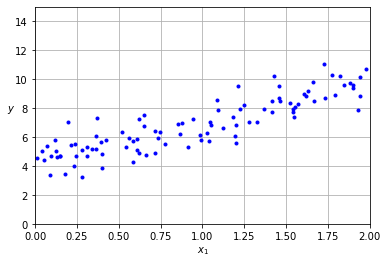

In [18]:
# generate some linear-ish data to test the Normal Equation

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # to make this code example reproducible
m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)  # column vector (y = 4 + 3x_1 + Gaussian noise)

# plot the generated data

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [2]:
# compute $\hat\theta$ using the Normal Equation

from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y # note: @ performs matrix mult.

In [8]:
theta_best.reshape(1,2)

array([[4.21509616, 2.77011339]])

We expect $\theta_0 = 4$ and $\theta_1 = 3$. We get values that are similar but slightly off (due to noise). Note that the smaller and noisier the dataset, the more the values will deviate.

Now we can make predictions using $\hat\theta$:

In [7]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict.reshape(1,2)

array([[4.21509616, 9.75532293]])

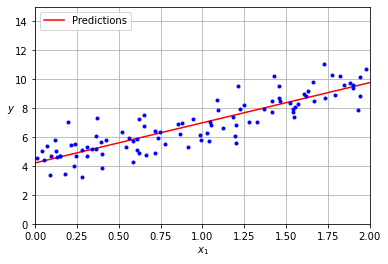

In [16]:
# plot the predictions

plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [19]:
# perform linear regression using SKL
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [24]:
lin_reg.predict(X_new).reshape(1,2)

array([[4.21509616, 9.75532293]])

SKL's ```LinearRegression``` class is based on ```scipy.linalg.lstsq()``` which can be directly called. This approach is more efficient than computing the normal equation and even works if $\text{X}^\text{T}\text{X}$ is not invertible. How it works is probably not too relevant for these notes though. Read the book for more information (Ch 4).

### Computational Complexity

The computational complexity (time complexity) of inverting a matrix is typically about $O(n^{2.4})$ or $O(n^3)$ depending on the implementation. In other words time scales exponentially with the number of features. The time complexity of the SVD approach used by SKL's ```LinearRegression``` class is about $O(n^2)$, which is also quite bad.

Once the linear regression model is trained, however, the time complexity of making a prediction is $O(n)$ with regards to both the number of instances you want to make predctions on and the number of features.

## Gradient Descent

Gradient descent is a generic optimization algorithm that is more suited for cases with a large number of features or too many instances to fit in memory. The general idea of gradient descent is to tweak parameters iteratively in order to minimize a cost function.

Gradient descent measures the local gradient of the error function with regard to parameter vector $\theta$ and goes in the direction of descending gradient, stopping once the gradient is zero.

In practice, start by filling $\theta$ with random values (aka random initialization), and then take small steps in the direction of decreasing cost until the algorithm converges to a minimum.

An important parameter in gradient descent is the size of the steps, determined by the *learning rate* hyperparameter. Too small and the algorithm might take too long or get stuck in a local minima (if one exists), too large and the algorithm might diverge to larger and larger values.

For a linear regression model, the MSE cost function is convex, implying no local minima and continuity. For this type of model, gradient descent is guaranteed to approach the global minimum (if you wait long enough and the learning rate is not too high).

If features have different scales, gradient descent will take longer to reach the minimum for the feature with the larger scale. You should ensure that all features have a similar scale, otherwise it may take a long time to converge.

Training a model often means searching for a combination of model parameters that minimizes a cost function. the more parameters a model has, harder the search will be (i.e., it will take longer). 

### Batch Gradient Descent

**Eq. 4-5. Parital Derivatives of the Cost function**

$$
\frac{\partial}{\partial\theta_j}\text{MSE}(\theta)=\frac{2}{m} \sum_{i=1}^m \left( \theta^T \textbf{x}^{(i)} - y^{(i)} \right) x_j^{(i)}
$$

We can compute all of the partial derivatives in one go. The gradient vector $\nabla_\theta \text{MSE}(\theta)$ contains all the partial derivatives of the cost function (one for each model parameter). See below:

**Eq. 4-6. Gradient Vector of the Cost Function**

$$
\nabla_\theta \text{MSE}(\theta) = 
\begin{pmatrix} \frac{\partial}{\partial\theta_0}\text{MSE}(\theta) \\
\frac{\partial}{\partial\theta_1}\text{MSE}(\theta) \\ \vdots \\
\frac{\partial}{\partial\theta_n}\text{MSE}(\theta) \end{pmatrix} = 
\frac{2}{m} \textbf{X}^{\text{T}} (\textbf{X} \theta - \textbf{y})
$$

Once the gradient vector is found, go in the opposite direction to go downhill, i.e., subtract $\nabla_\theta \text{MSE}(\theta)$ from $\theta$. Multiply the gradient vector by the learning rate $\eta$ to determine the size of the downhill step. See below:

**Eq. 4-7. Gradient Descent Step**

$$
\theta_{next step} = \theta - \eta\nabla_\theta\text{MSE}(\theta)
$$

In [25]:
# example implementation of the gradient descent algorithm

eta = 0.1  # learning rate
n_epochs = 1000
m = len(X_b)  # number of instances

np.random.seed(42)
theta = np.random.randn(2, 1)  # randomly initialized model parameters

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients
    
# note: each iteration over the training set is called an **epoch**

In [26]:
theta.reshape(1,2)

array([[4.21509616, 2.77011339]])

This is the same result that was obtained using the Normal Equation! Gradient descent worked perfectly. But what if we used a different learning rate (```eta```)? The graph produced by the following code shows the first 20 steps of gradient descent using three different learning rates. The line at the bottom of each plot represents the random starting point and each epoch is represented by a darker and darker line.

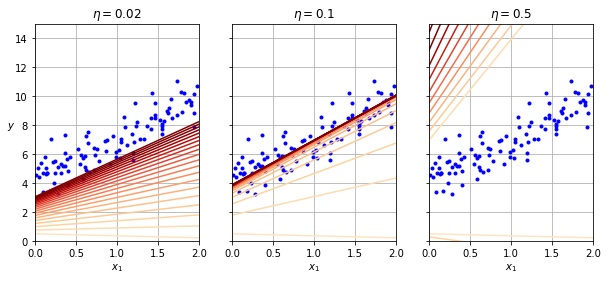

In [29]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

On the left, the learning rate is too low, and run time will be high. In the middle, the learning rate looks good. On the right, the learning rate is too high and the algorithm diverges.

You can use grid search to find a good learning rate. When doing so, it can be a good idea to limit the number of epochs so that grid search can eliminate models that take too long to converge.

### Stochastic Gradient Descent

Batch gradient descent can be very slow when the training set is large because it uses the whole training set to compute the gradients at every step. At the opposite extreme, *stochastic gradient descent* picks a random instance in the training set a every step and only computes the gradients based on that single instance. Stochastic Gradient Descent is much faster and makes it possible to train on huge training sets without excessive memory.

Since stochastic gradient descent is stochastic, when it converges near the minimum, the cost function will continue to bounce around but never point towrads a specific value. Once the algorithm stops, the final parameter values will be good, but not optimal.

Stochastic gradient descent has a better chance of finding the global minimum than batch gradient descent since when the cost function is very irregular, the algorithm can sometimes jump out of local minima. 

We can help the algorithm get closer to the minimum by gradually reducing the learning rate. The function that determines the learning rate at each iteration is called the *learning schedule*.

In [33]:
# code to implement SGD using a simple learning schedule

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

for epoch in range(n_epochs):
    for iteration in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        
# notice: the batch GD code iterated 1k times, 
# while SGD only iterated 50 times
# and they reach similar solutions
theta.reshape(1,2)

array([[4.21076011, 2.74856079]])

In [34]:
# SGD with SKLearn

from sklearn.linear_model import SGDRegressor

# SGDRegressor minimizes the MSE cost function by default jsyk
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets

# the solution is also similar to the one found by the Normal Equation
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent

At each step, mini-batch GD computes the gradients on small random sets of instances called *mini-batches*. The main advantage over SGD is that you can get a performance boost from hardware optimization of matrix operations. Also, mini-batch GD generally ends up slightly closer to the minimum than SGD, but it might also have more difficult escaping local minima.

Figure 4-11 in the book illustrates the differences between the three gradient descents with a graph. It is quite nice. Table 4-1 compares the algorithms discussed so far for linear regression with numbers. It's also very nice.

**note**: after training, all algorithms end up with very similar models and make predictions in the exact same way. 

## Polynomial Regression

You can use a linear model to fit nonlinear data. This can be done by adding powers of each feature as new features, and then taining a linear model on the extended set of features. This is called *polynomial regression*

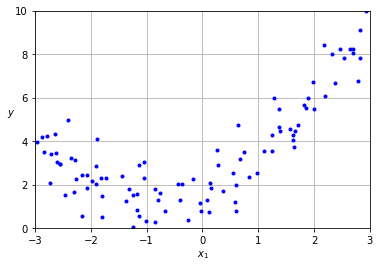

In [36]:
# generate some quadratic shape data with noise

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

# plot it just to show
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [38]:
# transform data using SKL's PolynomialFeatures class

from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X[0], X_poly[0]
# X_poly contains the original features of X and its square

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [39]:
# fit a linear regression model to the extended training data

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

These are good predictions. The model estimates $\hat y = 0.56x_1^2 + 0.93x_1 + 1.78$ when the original function was $y = 0.5x_1^2 + 1.0x_1 + 2.0 + \text{Gaussian noise}$.

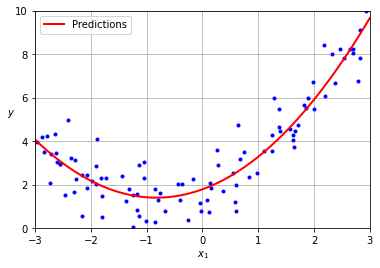

In [40]:
# plot best fit line for fun
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

When there are multiple features, polynomial regression is capable of finding relationships between features, which is something a plain linear regression model can't do.

## Learning Curves

High-degree polynomial regression will likely fit the trianing dat much better than plain linear regression. An excessively high-degree polynomial regression model serverely overfits the model while a linear model underfits. When you don't know the function that generates the data, it can be difficult to decide how complex a model should be.

One way to check under/over-fitting is cross validation. Another way is to look at *learning curves*. These are plots of the model’s training error and validation error as a function of the training iteration. To make these, evaluate the model at regular intervals during training on both the training set and the validation set, and plot the results. If the model cannot be trained incrementally, then it must be trained several times on gradually larger subsets of the training set.

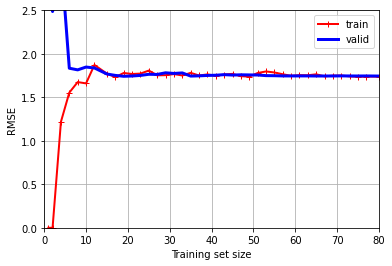

In [42]:
# plot learning curves of a linear model with SKL on the quadratic data

from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
    # if the model supports incremental training, set exploit_incremental_learning=True
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

The model is underfitting. When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, because the data is noisy and because it is not linear. The error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse.

When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite large. As the model is shown more training examples, it learns, and the validation error slowly goes down. However, once again a straight line cannot do a good job of modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

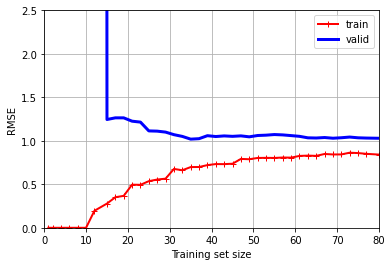

In [43]:
# learning curves of the 10th degree poly model on the same data

from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

These new curves look similar to the previous ones, but there are two important differences:
* The error on the training data is much lower than before.
* There is a gap between the curves, meaning the model performs significantly better on the training data than on the validation data. This signifies overfitting, but the two curves should converge if the training set is larger.

A model's generalization error can be expressed as the sum of three different errors:

* *Bias*: 
>Error due to incorrect assumptions (e.g., assuming that the data is linear when it is quadratic). A high-bias model is most likely to underfit the training data.
    
* *Variance*
>Error due to a model's excessive sensitivity to small variations in the training data (e.g., a high-degree polynomial model). A high variance model is likely to overfit the training data.

* *Irreducible Error*
>Error due to noise in the data. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, detect/remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is called the bias-variance trade-off.

## Regularized Linear Models

A good way to reduce overfitting is to regularize (constrain) the model. The fewer degrees of freedom that the model has, the harder it will be to overfit the data. One way to regulatize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. Three common ways to constrain the weights are ridge regression, lasso regression, and elastic net regression.

### Ridge Regression

*Ridge Regression* is a regularized version of linear regression. A *regularization term*, $\frac{\alpha}{m}\sum_{i=1}^n \theta_1^2$, is added to the MSE. The learning algorithm will fit the data while trying to keep the model weights as small as possible. **Note**: the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized MSE (or the RMSE) to evaluate the model’s performance.

The hyperparameter $\alpha$ controls how much you want to regularize the model. If α = 0, then ridge regression is just linear regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

**Eq. 4-8. Ridge Regression Cost Function**

$$
J(\theta) = \text{MSE}(\theta) + \frac{\alpha}{m}\sum_{i=1}^n \theta_1^2
$$

Notice that the bias term isn't regularized (the sum starts at $i=1$ not $i=0$).

<br>

Just like linear regression, we can perform ridge regression either by computing a closed-form equation or by performing gradient descent. The pros and cons are the same.

**Eq. 4-9. Ridge Regression Closed-Form Solution**

$$
\hat \theta = (\text{X}^\text{T}\text{X} + \alpha\text{A})^{-1} \text{X}^\text{T}\text{y}
$$

$\text{A}$ is the $(n + 1) \cdot  (n + 1)$ identity matrix,⁠ except with a $0$ in the top-left cell, corresponding to the bias term.

In [44]:
# ridge regression with SKL using a closed-form solution

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.82899748]])

In [45]:
# ridge regression using stochastic gradient descent

sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42) 
# the penalty hyperparameter sets the type of regularization term to use

sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([4.82830117])

### Lasso Regression

*Least absolute shrinkage and selection operator (LASSO) regression* is another regularized version of linear regression. It adds a regularization term to the cost fuction, but uses the $\ell_1$. Notice that the $\ell_1$ norm is multiplied by $2\alpha$, whereas the $\ell_2$ norm was multiplied by $\frac{\alpha}{m}$ in ridge regression. These factors were chosen to ensure that the optimal $\alpha$ value is independent from the training set size: different norms lead to different factors

**Eq. 4-10. Lasso Regression Cost Function**

$$
J(\theta) = \text{MSE}(\theta) + 2\alpha \sum_{i=1}^n |\theta_1|
$$

<br>

Lasso regression tends to eliminate the weights of the least important features (i.e., set them to zero). In other words, lasso regression automatically performs feature selection and outputs a sparse model with few nonzero feature weights.

The lasso cost function is not differentiable at $\theta_i = 0, \text{for } i=\mathbb{N}$, but gradient descent still works if you use a *subgradient vector* $g$ instead when any $\theta_i = 0$.

**Eq. 4-11. Lasso Regression Subgradient Vector**

$$
J(\theta) = \text{MSE}(\theta) + 2\alpha 
\begin{pmatrix}
\text{sign}(\theta_1) \\
\text{sign}(\theta_2) \\
\vdots \\
\text{sign}(\theta_n) \\
\end{pmatrix}
\text{, where sign}(\theta_1) = 
\begin{cases} 
-1 & \text{if } \theta_i < 0 \\
0 & \text{if } \theta_i = 0 \\
+1 & \text{if } \theta_i > 0
\end{cases}
$$

In [46]:
# SKL example using the Lasso class

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

# note alternative method: SGDRegressor(penalty="l1", alpha=0.1)

array([4.77621741])

### Elastic Net Regression

*Elastic net regression* is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso’s regularization terms, and you can control the mix ratio r. When r = 0, elastic net is equivalent to ridge regression, and when r = 1, it is equivalent to lasso regression.

**Eq. 4-12. Elastic Net Cost Function**

$$
J(\theta) = \text{MSE}(\theta) + r \left( 2\alpha \sum_{i=1}^n |\theta_1| \right) + \left( 1-r \right) \left( \frac{\alpha}{m} \sum_{i=1}^n \theta_i^2 \right)
$$

It is almost always preferable to have at least a little regularization. Ridge regression is a good default, but if you suspect that only a few features are useful, you should try lasso or elastic net regression because they reduce useless feature weights down to zero. In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [48]:
# example code using SKL's ElasticNet

from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) # l1_ratio corresponds to the mix ratio r
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### Early Stopping

Another way to regularize iterative learning algorithms (e.g., gradient descent) is to stop training as soon as validation error reaches a minimum. This is called *early stopping*.

As an algorithm learns, its prediction error on the training set goes down along with its prediction error on the validation set. Sometimes, after a while, the validation error stops decreasing and goes back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch”. **Even though all my STEM professors say that there is no such thing as free lunch.**

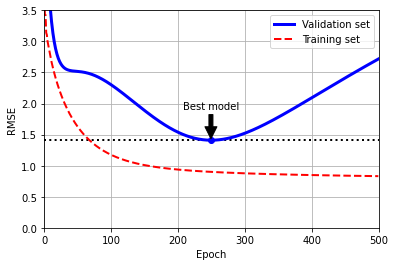

In [51]:
# basic implementation of early stopping

from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# extra code – creates the same quadratic dataset as earlier and splits it
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

# add all polynomial features and scale all input features
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

# create SGD model with no regularization and a small learning rate
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [], []  # extra code – it's for the figure below

for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train) # incremental learning
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    # measure RMSE at each epoch
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg) 
        # copy.deepcopy() copies both hyperparams and learning params
        # sklearn.base.clone() only copies a model's hyperparams
        
    # extra code – we evaluate the train error and save it for the figure
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)
    
# extra code – this section generates the early stopping plot
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()

## Logistic Regression

*Logistic Regression* (also called *logit regression*) is commonly used to estimate the probability that an instance belongs to a particular class. If the estimated probability is greater than a given threshold, then the model predicts that the instance belongs to that class, otherwise it predicts that it does not. Logit regression is a binary classifier.

### Estimating Probabilities

Logit regression works just like a linear regression model. It computes the weighted sum of the input features (plus a bias term), but instead of outputting the result directly (like lin reg), it outputs the logistic of the result.

**Eq. 4-13. Logistic Regression Model Estimated Probability (vectorized form)**

$$
\hat p = h_\theta (\text{x}) = \sigma ( \theta^T \text{x})
$$

The logistic (denoted $\sigma$) is a sigmoid function that ouputs a number between 0 and 1. It is defined as follows:

**Eq. 4-14. Logistic Function**

$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

Once the logistic regression model has estimated the probability $\hat p = h_\theta(\text{x})$ that an instance $x$ belongs to the positive class, it can make its prediction $\hat y$ easily:

**Eq. 4-15. Logistic Regression Model Prediction using a 0.5 Threshold Probability**

$$
\hat y = \begin{cases}
0 & \text{if } \hat p < 0.5 \\
1 & \text{if } \hat p \geq 0.5
\end{cases}
$$

A logistic model using the default threshold of 50% probabilty predicts $1$ if $\theta^T \text{x}$ is positive and $0$ if it is negative.

### Traning and Cost function

The objective of training a logit regression model is to set the parameter vector $\theta$ so that the model estimates high probabilities for positive instances $(y=1)$ and low probabilities for negative instances $(y=0)$.

**Eq. 4-16. Cost Function of a Single Training Instance**

$$
c(\theta) = \begin{cases}
-\log(\hat p) & \text{if } y=1 \\
-\log(1-\hat p) & \text{if } y=0
\end{cases}
$$

The cost function over the whole training set is the average cost over all training instances. It can be written as an expression called the *log loss*:

$$
J(\theta) = - \frac{1}{m} \sum_{i=1}^m \left[ y^{(i)} \log \left( \hat p^{(i)} \right) + \left( 1-y^{(i)} \right) \log \left( 1-\hat p^{(i)} \right) \right]
$$

note: log loss assumes a Gaussian distribution of data. If this assumption is wrong, then there will be consequences.

There is no known closed-form equation to compute the value of $\theta$, but since the cost function is convex, gradient descent (or any other optimization algorithm) is guaranteed to find the global minimum. The partial derivatives of the cost function with regard to the $j^{th}$ model parameter $\theta_j$ are given by:

**Eq. 4-18. Logistic Cost Function Partial Derivatives**

$$
\frac{\partial}{\partial\theta_j} J(\theta) = \frac{1}{m} \sum_{i=1}^m \left( \sigma \left( \theta^T \textbf{x}^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
$$

This equation is very similar to Eq. 4-5: for each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances. Once you have the gradient vector containing all the partial derivatives, you can use it in the batch gradient descent algorithm. For stochastic GD you would take one instance at a time, and for mini-batch GD you would use a mini-batch at a time.

### Decision Boundaries

We can use the iris dataset to illustrate logistic regression. This is a famous dataset that contains the sepal and petal length and width of 150 iris flowers of 3 species: *Iris setosa*, *Iris versicolor*, and *Iris virginica*.

We will build a classifier to detect the *Iris virginica* type based only on the petal width feature:

In [59]:
# load and peek at data

from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [60]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [61]:
iris.target.head(3)  # note that the instances are not shuffled

0    0
1    0
2    0
Name: target, dtype: int64

In [62]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [63]:
# split data and train logit model on traning set

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

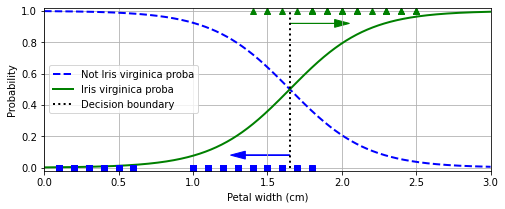

In [64]:
# look at estimated probabilities for petal widths between 0 cm and 3 cm

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies the logit reg plot
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
plt.show()

At above ~2cm the classifier is highly confident that the flower is an *Iris virginica*, while below ~1cm if is highly confident that the flower is not an *Iris virginica*. Between these lengths, however, the classifier is unsure. However, if you ask it to predict the class, it will return whichever class is the most likely. Therefore, there is a decision boundary at around 1.6 cm where both probabilities are equal to 50%. A prediction will be made, even if there is low confidence.

In [65]:
decision_boundary

1.6516516516516517

In [66]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

Just like the other linear models, logistic regression models can be regularized using $\ell_1$ or $\ell_2$ penalties. Scikit-Learn  adds an $\ell_1$ penalty by default.

### Softmax Regression

The logit regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers. This is called *softmax regression*, or multinomial logistic regression.